In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import cv2
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Conv2D, Concatenate, Flatten, Add, Dropout, GRU
import random
import datetime
from nltk.translate.bleu_score import sentence_bleu

In [2]:
dataset = pd.read_csv('Data.csv')
dataset.head()

,Person_id,Image1,Image2,Report
0,Scanned Images/CXR1_1_IM-0001_0,Scanned Images/CXR1_1_IM-0001-3001.png,Scanned Images/CXR1_1_IM-0001-4001.png,startseq the cardiac silhouette and mediastinu...
1,Scanned Images/CXR10_IM-0002_0,Scanned Images/CXR10_IM-0002-1001.png,Scanned Images/CXR10_IM-0002-2001.png,startseq the cardiomediastinal silhouette with...
2,Scanned Images/CXR100_IM-0002_0,Scanned Images/CXR100_IM-0002-1001.png,Scanned Images/CXR100_IM-0002-2001.png,startseq both lungs are clear and epanded . he...
3,Scanned Images/CXR1000_IM-0003_0,Scanned Images/CXR1000_IM-0003-1001.png,Scanned Images/CXR1000_IM-0003-2001.png,startseq there increased opacity within the ri...
4,Scanned Images/CXR1000_IM-0003_1,Scanned Images/CXR1000_IM-0003-1001.png,Scanned Images/CXR1000_IM-0003-3001.png,startseq there increased opacity within the ri...


In [3]:
X_train_img, X_cv_img, y_train_rep, y_cv_rep = train_test_split(dataset['Person_id'], dataset['Report'],
                                                                test_size = 0.3094146209873213, random_state=97)

In [4]:
X_train_img.shape, y_cv_rep.shape

((2560,), (1147,))

In [5]:
pad_size=155   # Max length

In [6]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(y_train_rep.values)

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [10]:
f = open('Xnet_Features.pickle','rb') # contains the features from chexNet
Xnet_Features = pickle.load(f)
f.close()

In [11]:
f = open('GLOVE_VECTORS.pickle','rb') # 300d glove vectors  
glove_vectors = pickle.load(f)
f.close()

In [12]:
vocab_size = len(tokenizer.word_index.keys()) + 1

In [13]:
embedding_matrix = np.zeros((vocab_size,300))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors.keys():
        vec = glove_vectors[word]
        embedding_matrix[i] = vec
    else:
        continue

In [14]:
BATCH_SIZE = 10

In [15]:
def load_image(id_, report):
    '''Loads the Image Features with their corresponding Ids'''
    img_feature = Xnet_Features[id_.decode('utf-8')][0]
    return img_feature, report

In [16]:
def create_dataset(img_name_train,caption_train):
  
    dataset = tf.data.Dataset.from_tensor_slices((img_name_train, caption_train))

  # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_image, [item1, item2], [tf.float32, tf.string]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
    dataset = dataset.shuffle(500).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [17]:
train_dataset = create_dataset(X_train_img, y_train_rep)
cv_dataset = create_dataset(X_cv_img, y_cv_rep)

In [18]:
def bytes_to_string(arr):
    '''The generator gives provides data in bytes. This function converts them back to strings for manipulation'''
    for i in range(len(arr)):
        arr[i] = arr[i].decode('utf-8')
    return arr

In [19]:
def convert(images, reports):
    '''This function takes the batch of data and converts them into a new dataset(A WORD BY WORD DATASET)'''
    imgs = []
    in_reports = []
    out_reports = []
    for i in range(len(images)):
        sequence = [tokenizer.word_index[e] for e in reports[i].split() if e in tokenizer.word_index.keys()]
      #  print(sequence)
        for j in range(1,len(sequence)):

            in_seq = sequence[:j]
            out_seq = sequence[j]
            out_seq = tf.keras.utils.to_categorical(out_seq, num_classes=vocab_size)

            imgs.append(images[i])
          #  print(in_seq)
            in_reports.append(in_seq)
           # print(out_seq)
            out_reports.append(out_seq)
        
    return np.array(imgs), np.array(in_reports), np.array(out_reports)

In [20]:
np.random.seed(42)

##fixing tensorflow RS
tf.random.set_seed(32)

##python RS
random.seed(12)

In [21]:
input1 = Input(shape=(2048), name='Image_1')
dense1 = Dense(256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 56), name='dense_encoder')(input1)

input2 = Input(shape=(155), name='Text_Input')
emb_layer = Embedding(input_dim = vocab_size, output_dim = 300, input_length=155, mask_zero=True, trainable=False, 
                weights=[embedding_matrix], name="Embedding_layer")
emb = emb_layer(input2)

LSTM2 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), name="LSTM2")
LSTM2_output = LSTM2(emb)

dropout1 = Dropout(0.5, name='dropout1')(LSTM2_output)

dec =  tf.keras.layers.Add()([dense1, dropout1])

fc1 = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed = 63), name='fc1')
fc1_output = fc1(dec)
output_layer = Dense(vocab_size, activation='softmax', name='Output_layer')
output = output_layer(fc1_output)

encoder_decoder = Model(inputs = [input1, input2], outputs = output)
encoder_decoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Text_Input (InputLayer)         [(None, 155)]        0                                            
__________________________________________________________________________________________________
Embedding_layer (Embedding)     (None, 155, 300)     421500      Text_Input[0][0]                 
__________________________________________________________________________________________________
Image_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
LSTM2 (LSTM)                    (None, 256)          570368      Embedding_layer[0][0]            
______________________________________________________________________________________________

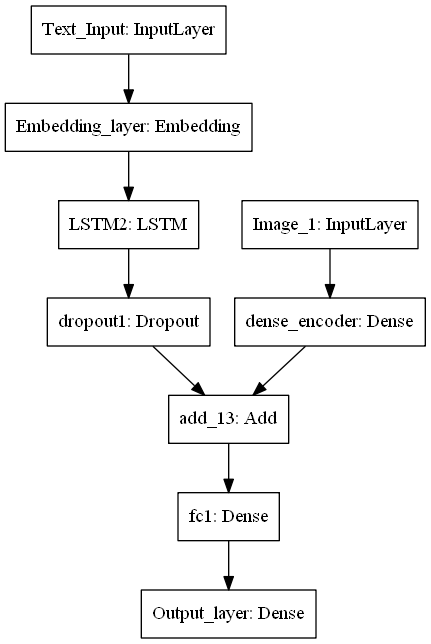

In [116]:
tf.keras.utils.plot_model(encoder_decoder)

In [117]:
optimizer = tf.keras.optimizers.Adam(0.001)

In [89]:
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='auto')

def maskedLoss(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    
    #calculating the loss
    loss_ = loss_function(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_

In [90]:
encoder_decoder.compile(optimizer, loss = maskedLoss)

In [91]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'Tensorboard/logs_m3/fit5/' + current_time + '/train'
val_log_dir = 'Tensorboard/logs_m3/fit5/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
val_summary_writer = tf.summary.create_file_writer(val_log_dir)

## Training for epochs 1-20

In [123]:
epoch_train_loss = []
epoch_val_loss = []

for epoch in range(20):
    print('EPOCH : ',epoch+1)
    start = time.time()
    batch_loss_tr = 0
    batch_loss_vl = 0
    
    for img, report in train_dataset:
       
        r1 = bytes_to_string(report.numpy())
        img_input, rep_input, output_word = convert(img.numpy(), r1)
        rep_input = pad_sequences(rep_input, maxlen=155, padding='post')
        results = encoder_decoder.train_on_batch([img_input, rep_input], output_word)
        
        batch_loss_tr += results

    train_loss = batch_loss_tr/(X_train_img.shape[0]//10)
 #   print('Saving Tensorboard')
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step = epoch)
    
    for img, report in cv_dataset:
        
        r1 = bytes_to_string(report.numpy())
        img_input, rep_input, output_word = convert(img.numpy(), r1)
        rep_input = pad_sequences(rep_input, maxlen=155, padding='post')
        results = encoder_decoder.test_on_batch([img_input, rep_input], output_word)
        batch_loss_vl += results
    
    val_loss = batch_loss_vl/(X_cv_img.shape[0]//10)
    
    with val_summary_writer.as_default():
        tf.summary.scalar('loss', val_loss, step = epoch)

    epoch_train_loss.append(train_loss)

    epoch_val_loss.append(val_loss)
    
    print('Training Loss: {},  Val Loss: {}'.format(train_loss, val_loss))
    print('Time Taken for this Epoch : {} sec'.format(time.time()-start))   
    encoder_decoder.save_weights('Weights/BM7_new_model1_epoch_'+ str(epoch+1) + '.h5')

EPOCH :  1
Training Loss: 0.0028966069589841936,  Val Loss: 0.0021542243929089685
Time Taken for this Epoch : 23.579204559326172 sec
EPOCH :  2
Training Loss: 0.0019562640891308547,  Val Loss: 0.0017601502272953983
Time Taken for this Epoch : 14.455883264541626 sec
EPOCH :  3
Training Loss: 0.0016780756868683966,  Val Loss: 0.0015751209555259138
Time Taken for this Epoch : 14.525048732757568 sec
EPOCH :  4
Training Loss: 0.00152934992433984,  Val Loss: 0.0014563908426728296
Time Taken for this Epoch : 14.128231763839722 sec
EPOCH :  5
Training Loss: 0.0014233998001600412,  Val Loss: 0.0013940949554620474
Time Taken for this Epoch : 15.233656406402588 sec
EPOCH :  6
Training Loss: 0.001336231786353892,  Val Loss: 0.0013491677910726714
Time Taken for this Epoch : 14.19428014755249 sec
EPOCH :  7
Training Loss: 0.0012704101520739641,  Val Loss: 0.0013157685804017411
Time Taken for this Epoch : 14.94893765449524 sec
EPOCH :  8
Training Loss: 0.0012079719838311576,  Val Loss: 0.001303457615

## Training for epochs 20-30

In [134]:
epoch_train_loss = []
epoch_val_loss = []

for epoch in range(20,30):
    print('EPOCH : ',epoch+1)
    start = time.time()
    batch_loss_tr = 0
    batch_loss_vl = 0
    
    for img, report in train_dataset:
       
        r1 = bytes_to_string(report.numpy())
        img_input, rep_input, output_word = convert(img.numpy(), r1)
        rep_input = pad_sequences(rep_input, maxlen=155, padding='post')
        results = encoder_decoder.train_on_batch([img_input, rep_input], output_word)
        
        batch_loss_tr += results

    train_loss = batch_loss_tr/(X_train_img.shape[0]//10)
 #   print('Saving Tensorboard')
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step = epoch)
    
    for img, report in cv_dataset:
        
        r1 = bytes_to_string(report.numpy())
        img_input, rep_input, output_word = convert(img.numpy(), r1)
        rep_input = pad_sequences(rep_input, maxlen=155, padding='post')
        results = encoder_decoder.test_on_batch([img_input, rep_input], output_word)
        batch_loss_vl += results
    
    val_loss = batch_loss_vl/(X_cv_img.shape[0]//10)
    
    with val_summary_writer.as_default():
        tf.summary.scalar('loss', val_loss, step = epoch)

    epoch_train_loss.append(train_loss)

    epoch_val_loss.append(val_loss)
    
    print('Training Loss: {},  Val Loss: {}'.format(train_loss, val_loss))
    print('Time Taken for this Epoch : {} sec'.format(time.time()-start))   
    encoder_decoder.save_weights('Weights/BM7_new_model1_epoch_'+ str(epoch+1) + '.h5')

EPOCH :  21
Training Loss: 0.0008057316224494571,  Val Loss: 0.001227356815657562
Time Taken for this Epoch : 14.041675329208374 sec
EPOCH :  22
Training Loss: 0.0007995327091521176,  Val Loss: 0.0012603285911354121
Time Taken for this Epoch : 15.313365459442139 sec
EPOCH :  23
Training Loss: 0.0007772460181740826,  Val Loss: 0.0012541428538194548
Time Taken for this Epoch : 14.080343008041382 sec
EPOCH :  24
Training Loss: 0.0007655928245640098,  Val Loss: 0.0012535887199511197
Time Taken for this Epoch : 14.64665412902832 sec
EPOCH :  25
Training Loss: 0.0007457995608319834,  Val Loss: 0.0012454559134008984
Time Taken for this Epoch : 14.117677211761475 sec
EPOCH :  26
Training Loss: 0.0007327409396111761,  Val Loss: 0.0012420808917867315
Time Taken for this Epoch : 14.46177053451538 sec
EPOCH :  27
Training Loss: 0.0007149813209252898,  Val Loss: 0.001267771149542297
Time Taken for this Epoch : 15.307510137557983 sec
EPOCH :  28
Training Loss: 0.000703105307138685,  Val Loss: 0.0012

## Training for epochs 30-40

In [145]:
epoch_train_loss = []
epoch_val_loss = []

for epoch in range(30, 40):
    print('EPOCH : ',epoch+1)
    start = time.time()
    batch_loss_tr = 0
    batch_loss_vl = 0
    
    for img, report in train_dataset:
       
        r1 = bytes_to_string(report.numpy())
        img_input, rep_input, output_word = convert(img.numpy(), r1)
        rep_input = pad_sequences(rep_input, maxlen=155, padding='post')
        results = encoder_decoder.train_on_batch([img_input, rep_input], output_word)
        
        batch_loss_tr += results

    train_loss = batch_loss_tr/(X_train_img.shape[0]//10)
 #   print('Saving Tensorboard')
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step = epoch)
    
    for img, report in cv_dataset:
        
        r1 = bytes_to_string(report.numpy())
        img_input, rep_input, output_word = convert(img.numpy(), r1)
        rep_input = pad_sequences(rep_input, maxlen=155, padding='post')
        results = encoder_decoder.test_on_batch([img_input, rep_input], output_word)
        batch_loss_vl += results
    
    val_loss = batch_loss_vl/(X_cv_img.shape[0]//10)
    
    with val_summary_writer.as_default():
        tf.summary.scalar('loss', val_loss, step = epoch)

    epoch_train_loss.append(train_loss)

    epoch_val_loss.append(val_loss)
    
    print('Training Loss: {},  Val Loss: {}'.format(train_loss, val_loss))
    print('Time Taken for this Epoch : {} sec'.format(time.time()-start))   
    encoder_decoder.save_weights('Weights/BM7_new_model1_epoch_'+ str(epoch+1) + '.h5')

EPOCH :  31
Training Loss: 0.000666852402105178,  Val Loss: 0.0013062685019369319
Time Taken for this Epoch : 13.874699115753174 sec
EPOCH :  32
Training Loss: 0.0006547168727593089,  Val Loss: 0.0012872591333896771
Time Taken for this Epoch : 13.763872623443604 sec
EPOCH :  33
Training Loss: 0.0006486363139401874,  Val Loss: 0.001310949107599363
Time Taken for this Epoch : 14.267862558364868 sec
EPOCH :  34
Training Loss: 0.0006375133825713419,  Val Loss: 0.0013070465356577188
Time Taken for this Epoch : 13.998978614807129 sec
EPOCH :  35
Training Loss: 0.0006293521777251954,  Val Loss: 0.001388719677363457
Time Taken for this Epoch : 14.298990488052368 sec
EPOCH :  36
Training Loss: 0.0006197963695058206,  Val Loss: 0.0013535453204224866
Time Taken for this Epoch : 14.397833585739136 sec
EPOCH :  37
Training Loss: 0.0006140475469464945,  Val Loss: 0.0013309109229962097
Time Taken for this Epoch : 14.795084238052368 sec
EPOCH :  38
Training Loss: 0.0006066850222623543,  Val Loss: 0.00

## Inference Setup

In [146]:
# encoder
encoder_input = encoder_decoder.input[0]
encoder_output = encoder_decoder.get_layer('dense_encoder').output
encoder_model = Model(encoder_input, encoder_output)

# decoder# 
text_input = encoder_decoder.input[1]
enc_output = Input(shape=(256,), name='Enc_Output')
text_output = encoder_decoder.get_layer('LSTM2').output
add1 = tf.keras.layers.Add()([text_output, enc_output])
fc_1 = fc1(add1)
decoder_output = output_layer(fc_1)

decoder_model = Model(inputs = [text_input, enc_output], outputs = decoder_output)

In [147]:
def greedysearch(img):
    image = Xnet_Features[img]
    input_ = 'startseq'
    image_features = encoder_model.predict(image)
    
    result = []
    for i in range(155):
        input_tok = [tokenizer.word_index[w] for w in input_.split()]
        input_padded = pad_sequences([input_tok], 155, padding='post')
        predictions = decoder_model.predict([input_padded, image_features])
        arg = np.argmax(predictions)
        if arg != 7:   # endseq
            result.append(tokenizer.index_word[arg])
            input_ = input_ + ' ' + tokenizer.index_word[arg]
        else:
            break
    rep = ' '.join(e for e in result)
    return rep

# Eg: 1

In [126]:
res36 = greedysearch(X_cv_img.values[36]) # result after 20 epochs
res36

'the heart normal size . the mediastinum unremarkable . the lungs are hypoinflated but grossly clear .'

In [137]:
res36 = greedysearch(X_cv_img.values[36]) # result after 30 epochs
res36

'the heart size and pulmonary vascularity appear within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora seen .'

In [148]:
res36 = greedysearch(X_cv_img.values[36]) # result after 40 epochs
res36

'the heart normal size and contour . there no mediastinal widening . no focal airspace disease . no pleural effusion pneumothora . the visualized bony structures reveal no acute abnormalities .'

In [158]:
y_cv_rep.values[36]  # original

'startseq heart size and pulmonary vascularity within normal limits . no focal infiltrate pneumothora pleural effusion identified . endseq'

# Eg: 2

In [127]:
res72 = greedysearch(X_cv_img.values[72]) # result after 20 epochs
res72

'the heart and lungs have the interval . both lungs are clear and epanded . heart and mediastinum normal .'

In [138]:
res72 = greedysearch(X_cv_img.values[72]) # result after 30 epochs
res72

'the heart normal size . the mediastinum unremarkable . the lungs are clear .'

In [149]:
res72 = greedysearch(X_cv_img.values[72]) # result after 40 epochs
res72

'the heart normal size and contour . there no mediastinal widening . the lungs are clear bilaterally . no large pleural effusion pneumothora . the are intact .'

In [161]:
y_cv_rep.values[72] # original

'startseq the heart normal size . the mediastinum unremarkable . the lungs are clear . endseq'

# Eg: 3

In [128]:
res108 = greedysearch(X_cv_img.values[108])  # result after 20 epochs
res108

'the heart size and pulmonary vascularity appear within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora seen .'

In [139]:
res108 = greedysearch(X_cv_img.values[108])  # result after 30 epochs
res108

'the heart size normal . the mediastinal contour within normal limits . the lungs are free any focal infiltrates . there are no nodules masses . no visible pneumothora . no visible pleural fluid . the are grossly normal . there no visible free intraperitoneal air under the diaphragm .'

In [150]:
res108 = greedysearch(X_cv_img.values[108])  # result after 40 epochs
res108

'the heart size and mediastinal silhouette are within normal limits for contour . the lungs are clear . no pneumothora pleural effusions . the are intact .'

In [104]:
y_cv_rep.values[108] # original

'startseq lungs are hyperinflated but clear . no focal infiltrate effusion . heart and mediastinal contours within normal limits . calcified mediastinal identified . endseq'

# Eg: 4

In [129]:
res37 = greedysearch(X_train_img.values[37])  # result after 20 epochs
res37

'the heart normal size . the mediastinum unremarkable . the lungs are clear .'

In [140]:
res37 = greedysearch(X_train_img.values[37])  # result after 30 epochs
res37

'the heart normal size . the mediastinum unremarkable . the lungs are clear .'

In [151]:
res37 = greedysearch(X_train_img.values[37])  # result after 40 epochs
res37

'the heart normal size . the mediastinum unremarkable . there no pleural effusion pneumothora focal airspace disease . there stable calcified granuloma within the left lower lobe . there are stable chronic degenerative changes the thoracic spine .'

In [106]:
y_train_rep.values[37] # original

'startseq heart size normal . the lungs are clear . there are no focal air space consolidations . no pleural effusions pneumothoraces . aortic vascular calcifications . normal pulmonary vascularity . fracturedislocation the right shoulder . bone demineralization . scoliosis which possibly positional . endseq'

# Eg: 5

In [130]:
res0 = greedysearch(X_train_img.values[0]) # result after 20 epochs
res0

'the heart normal size . the mediastinum unremarkable . the lungs are clear .'

In [141]:
res0 = greedysearch(X_train_img.values[0]) # result after 30 epochs
res0

'the heart normal size . the mediastinum unremarkable . the lungs are clear .'

In [152]:
res0 = greedysearch(X_train_img.values[0]) # result after 40 epochs
res0

'the heart normal size and contour . there no mediastinal widening . the lungs are clear bilaterally . no large pleural effusion pneumothora . the are intact .'

In [109]:
y_train_rep.values[0] # original

'startseq there nodular density the left lung base . lungs are otherwise clear . the ct scan without contrast could performed for further evaluation . no pleural effusions pneumothoraces . heart and mediastinum normal size and contour . degenerative changes the thoracic spine . endseq'

# Eg: 6

In [131]:
res45 = greedysearch(X_train_img.values[45]) # result after 20 epochs
res45

'the heart normal size . the mediastinum unremarkable . the lungs are clear .'

In [142]:
res45 = greedysearch(X_train_img.values[45]) # result after 30 epoch
res45

'the heart size normal . the mediastinal contour within normal limits . the lungs are free any focal infiltrates . there are no nodules masses . no visible pneumothora . no visible pleural fluid . the are grossly normal . there no visible free intraperitoneal air under the diaphragm .'

In [153]:
res45 = greedysearch(X_train_img.values[45]) # result after 40 epoch
res45

'the heart normal size and contour . there no mediastinal widening . no focal airspace disease . no large pleural effusion pneumothora . the are intact .'

In [44]:
y_train_rep.values[45] # original

'startseq stable cardiomediastinal silhouette . elevated right hemidiaphragm . atelectasis the right lung base . no focal pulmonary consolidation pleural effusion pneumothora . no acute bony abnormality . degenerative changes the thoracic spine . endseq'

# Eg: 7

In [132]:
res100 = greedysearch(X_train_img.values[100])# result after 20 epochs
res100

'the heart and lungs have the interval . both lungs are clear and epanded . heart and mediastinum normal .'

In [143]:
res100 = greedysearch(X_train_img.values[100])# result after 30 epochs
res100

'the heart size and pulmonary vascularity appear within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora seen .'

In [154]:
res100 = greedysearch(X_train_img.values[100])# result after 40 epochs
res100

'the heart normal size . the mediastinum unremarkable . the lungs are hypoinflated but grossly clear .'

In [46]:
y_train_rep.values[100] # original

'startseq heart size normal . lungs are clear . are normal . no pneumonia effusions edema pneumothora adenopathy nodules masses . endseq'

# Eg: 8

In [133]:
res1234 = greedysearch(X_train_img.values[1234]) # result after 20 epochs
res1234

'the heart and lungs have the interval . both lungs are clear and epanded . heart and mediastinum normal .'

In [144]:
res1234 = greedysearch(X_train_img.values[1234]) # result after 30 epochs
res1234

'the heart size and pulmonary vascularity appear within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora seen .'

In [155]:
res1234 = greedysearch(X_train_img.values[1234]) # result after 40 epochs
res1234

'low lung volumes . question airspace disease identified . heart size within normal limits . no pneumothora pleural effusion . no acute osseous abnormality .'

In [49]:
y_train_rep.values[1234]  # original

'startseq the cardiomediastinal silhouette normal . the lungs are clear . there no pneumothora pneumomediastinum . visualized bony structures are normal . endseq'

## BLEU SCORE

In [8]:
def rem_fullstops(text):
    '''Removes punctuations'''
    punctuations = '''.''' # full stop is not removed
    new_text = []
    for char in text:
        if char in punctuations: 
            text = text.replace(char, "")
    new_text.append(' '.join(e for e in text.split()))
    return new_text[0]

# 35 epochs

In [74]:
#encoder_decoder.load_weights('Weights/BM7_new_model1_epoch_35.h5')

In [75]:
bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []
for img, rep in tqdm(zip(X_cv_img.values, y_cv_rep.values)):
    
    rep = rem_fullstops(rep)
    rep = rep.split()[1:]
    rep = rep[:len(rep)-1]
    rep = ' '.join(e for e in rep)
    
    pred_rep = greedysearch(img)
    pred_rep = rem_fullstops(pred_rep)
    
    bleu1.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (1,0,0,0)))
    bleu2.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.5,0.5,0,0)))
    bleu3.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.33,0.33,0.33,0)))
    bleu4.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.25,0.25,0.25,0.25)))

1147it [15:31,  1.23it/s]


In [76]:
print('Bleu1 Score: ', sum(bleu1)/X_cv_img.shape[0])
print('Bleu2 Score: ', sum(bleu2)/X_cv_img.shape[0])
print('Bleu3 Score: ', sum(bleu3)/X_cv_img.shape[0])
print('Bleu4 Score: ', sum(bleu4)/X_cv_img.shape[0])

Bleu1 Score:  0.32310065402698124
Bleu2 Score:  0.19833500401064233
Bleu3 Score:  0.12312126770345183
Bleu4 Score:  0.064104997138134
